<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2021/Assignments/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
\begin{equation}
\begin{split}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2) & \qquad\text{Output of the network}
\end{split}
\end{equation}

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data floing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_1\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tqdm

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

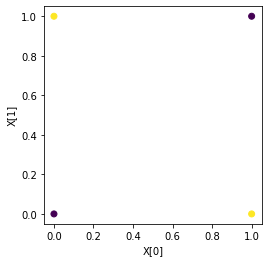

In [28]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    x = x.copy()
    x[x <= 0] = 0
    return x

In [30]:
class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32, verbose = False):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params(in_features, num_hidden)
        self.verbose = verbose

    def init_params(self, in_features, num_hidden):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(scale = 0.5, size = (num_hidden, in_features))
        self.b1 = np.random.normal(scale = 0.5, size = (num_hidden,))
        self.W2 = np.random.normal(scale = 0.5, size = (1, num_hidden))
        self.b2 = np.random.normal(scale = 0.5, size = (1,))

    def forward(self, X, Y=None, do_backward=False, first_activation_f = sigmoid):
        # TODO Problem 1: Fill in details of forward propagation
        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = first_activation_f(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)
        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -(Y * np.log(O2) + (1 - Y) * np.log(1.0 - O2))
            if(self.verbose):
                print("Y:", Y)
                print("O2:", O2)
                print("Loss vector:", loss)
                print()
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            if self.verbose:
                print(f"W1: \n{self.W1}")
                print(f"b1: \n{self.b1}")
                print(f"W2: \n{self.W2}")
                print(f"b2: \n{self.b2}")
                print(f"A1: \n{A1}")
                print(f"A2: \n{A2}")
                print(f"O1: \n{O1}")
                print(f"O2: \n{O2}")
                
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / A2_grad.shape[0]
            self.W2_grad = A2_grad.T @ O1 / A2_grad.shape[0]
            O1_grad = A2_grad @ self.W2
            if first_activation_f == sigmoid:
                A1_grad = O1_grad * sigmoid(A1) * (1 - sigmoid(A1))
            elif first_activation_f == relu:
                A1_grad = O1_grad * np.where(A1 > 0, 1, 0)
            self.b1_grad = A1_grad.sum(0) / A2_grad.shape[0]
            self.W1_grad = A1_grad.T @ X / A1_grad.shape[0]

        return O2, loss

In [32]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64, verbose = False)
net.W1 = np.array([[8, 8], [-8, -8]])
net.b1 = np.array([-4, 12])
net.W2 = np.array([[8, 8]])
net.b2 = np.array([-12])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y)
for x, p in zip(X, predictions):
    print(f"XOR{x} = {p}")
print(f"Loss: {loss}")

XOR[0. 0.] = [0.02071105]
XOR[0. 1.] = [0.97615905]
XOR[1. 0.] = [0.97615905]
XOR[1. 1.] = [0.02071105]
Loss: 0.022529139712188447


## Problem 2

In [15]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)
    
    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    print(f"{param_name}")
    print(f"grad:\n{grad}")
    print(f"orig_grad:\n{orig_grad}")
    print("")
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [16]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64, verbose = False)
# check_grad(net, "W1", X, Y)
# check_grad(net, "b1", X, Y)
# check_grad(net, "W2", X, Y)
# check_grad(net, "W1", X, Y)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

W1
grad:
[[0.00081201 0.00127191]
 [0.01546466 0.01464961]]
orig_grad:
[[0.00081201 0.00127191]
 [0.01546466 0.01464961]]

b1
grad:
[0.00181548 0.02489895]
orig_grad:
[0.00181548 0.02489895]

W2
grad:
[[-0.05628556 -0.07744697]]
orig_grad:
[[-0.05628556 -0.07744697]]

b2
grad:
[-0.12046262]
orig_grad:
[-0.12046262]



## Problem 3

In [17]:
def gradient_descent(net, alpha, X, Y, verbose = True, first_activation_f = sigmoid):
    for i in range(100000):
        net_result, loss = net.forward(X, Y, do_backward=True, first_activation_f = first_activation_f)
        if (i % 5000) == 0 and verbose:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            # alternatively, you could do setattr(net, param_name, new_value)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    params = {"W1": [], "W2": [], "b1": [], "b2": []}
    for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            params[param_name] = param
    
    return net_result, loss, params

In [18]:
net = SmallNet(2, 10, dtype=np.float64)
_ = gradient_descent(net, 0.1, X, Y)

after 0 steps 	loss=0.6890006290693758
after 5000 steps 	loss=0.030055767392975614
after 10000 steps 	loss=0.009259683323291114
after 15000 steps 	loss=0.005242382428042287
after 20000 steps 	loss=0.00359708480216515
after 25000 steps 	loss=0.002714195044802998
after 30000 steps 	loss=0.002167641711506374
after 35000 steps 	loss=0.0017977820423570041
after 40000 steps 	loss=0.0015317513326464907
after 45000 steps 	loss=0.0013317043850367707
after 50000 steps 	loss=0.0011760944834265045
after 55000 steps 	loss=0.0010517800625109335
after 60000 steps 	loss=0.0009503043538096516
after 65000 steps 	loss=0.0008659861275497082
after 70000 steps 	loss=0.0007948716441069324
after 75000 steps 	loss=0.0007341270067274652
after 80000 steps 	loss=0.0006816694996796233
after 85000 steps 	loss=0.0006359351901291702
after 90000 steps 	loss=0.000595727549483613
after 95000 steps 	loss=0.0005601160121057086


In [19]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.0003280331044678273
XORnet([0. 1.]) = 0.9995270010466416
XORnet([1. 0.]) = 0.9993774453616577
XORnet([1. 1.]) = 0.0006892812211461862


### For 3D XOR being (x1 xor x2 xor x3)

In [20]:
values = [1, 0]
X3 = np.zeros(shape = (8, 3), dtype = np.float64)
Y3 = np.zeros(shape = (8, 1), dtype = np.float64)
for index, single_input in enumerate(itertools.product(values, repeat = 3)):
    X3[index, :] = single_input
    Y3[index, 0] = single_input[0] ^ single_input[1] ^ single_input[2]
print(f"X3:\n{X3}")
print(f"Y3:\n{Y3}\n")

X3:
[[1. 1. 1.]
 [1. 1. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
Y3:
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]



In [21]:
dims = [2, 3, 10]
for hidden_dim in dims:
    # TODO: run a few trainings and record the fraction of successful ones
    print(f"Trying hidden_dim = {hidden_dim}")
    for i in range(10):
        net = SmallNet(3, hidden_dim, dtype=np.float64)
        res, loss, _ = gradient_descent(net, 
                                     alpha = 0.1, 
                                     X = X3, 
                                     Y = Y3, 
                                     verbose = False, 
                                     first_activation_f = sigmoid)
        print("\nLOSS:", loss)
        print("RESULT:")
        for single_input, single_output, single_true_value in zip(X3, res, Y3):
            print(f"netXOR({single_input}) = {single_output}  TRUE VALUE: {single_true_value}")
    print("\n")

Trying hidden_dim = 2

LOSS: 0.34750495634377865
RESULT:
netXOR([1. 1. 1.]) = [0.99924591]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.50048339]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.50059463]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99928737]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00074434]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.49938571]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.499469]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.00078958]  TRUE VALUE: [0.]

LOSS: 0.35167915496496427
RESULT:
netXOR([1. 1. 1.]) = [0.49860263]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.5034031]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.00437579]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99548328]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00437572]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99548335]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.49749526]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.50416742]  TRUE VALUE: [0.]

LOSS: 0.2829726828376406
RESULT:
netXOR([1. 1. 1.]) = [0.25025016]  TRUE VALUE


LOSS: 0.0016185767207178088
RESULT:
netXOR([1. 1. 1.]) = [0.99831091]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.00218946]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.00051254]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99819517]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00195145]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99941761]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.99801719]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.00222394]  TRUE VALUE: [0.]


Trying hidden_dim = 10

LOSS: 0.0005713347114474669
RESULT:
netXOR([1. 1. 1.]) = [0.99963504]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.00045198]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.00070017]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99926673]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00050192]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99923686]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.99948835]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.00054221]  TRUE VALUE: [0.]

LOSS: 0.0005887282584578003
RESULT:
netXOR([1. 1. 1.]) = [0.99962102

    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR

Minimal hidden size to solve 3D XOR with low reliability is 2.<br/>
To get the net that solves the 3D XOR every time, hidden size should be >= 3. 

    - Which networks are easier to train - small or large ones? Why?
It's easier to train large networks (especially the ones that have more neurons in each layer). Since they have many parameters and their expressive power is bigger, it should be easier to find some parameters that can improve the result if they are tweaked. 

## Problem 4


Test for 2D XOR just to check if relu works. 

In [22]:
net = SmallNet(2, 10, dtype=np.float64)
_ = gradient_descent(net, 0.1, X, Y, first_activation_f=relu)

after 0 steps 	loss=1.009950689000232
after 5000 steps 	loss=0.0012716735795765377
after 10000 steps 	loss=0.0005303224201617145
after 15000 steps 	loss=0.0003241214307221626
after 20000 steps 	loss=0.00022998932025274885
after 25000 steps 	loss=0.00017676465957361203
after 30000 steps 	loss=0.0001427953255196807
after 35000 steps 	loss=0.00011934804841575266
after 40000 steps 	loss=0.0001022425417469736
after 45000 steps 	loss=8.924592501986784e-05
after 50000 steps 	loss=7.905713843625356e-05
after 55000 steps 	loss=7.086659884999192e-05
after 60000 steps 	loss=6.414714923502873e-05
after 65000 steps 	loss=5.854154030351328e-05
after 70000 steps 	loss=5.379730069583925e-05
after 75000 steps 	loss=4.9732845282410646e-05
after 80000 steps 	loss=4.6214664688157164e-05
after 85000 steps 	loss=4.314055207218734e-05
after 90000 steps 	loss=4.0433007601237426e-05
after 95000 steps 	loss=3.803152715845821e-05


Finding an architecture that reliably learns to solve 3D XOR

In [26]:
dims = [9]
for hidden_dim in dims:
    print(f"Trying hidden_dim = {hidden_dim}")
    for i in range(10):
        net = SmallNet(3, hidden_dim, dtype=np.float64)
        res, loss, params = gradient_descent(net, 
                                     alpha = 0.1, 
                                     X = X3, 
                                     Y = Y3, 
                                     verbose = False, 
                                     first_activation_f = relu)
        print("\nLOSS:", loss)
        print("RESULT:")
        for single_input, single_output, single_true_value in zip(X3, res, Y3):
            print(f"netXOR({single_input}) = {single_output}  TRUE VALUE: {single_true_value}")
#         print("PARAMS:")
#         for param_name in params.keys():
#             print(param_name)
#             print(params[param_name])
    print("\n")

Trying hidden_dim = 9

LOSS: 0.00011176906410235318
RESULT:
netXOR([1. 1. 1.]) = [0.99988513]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [9.87928136e-05]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.0001552]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99987448]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00010542]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99995386]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.99985472]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.00010289]  TRUE VALUE: [0.]

LOSS: 0.00014003808410211933
RESULT:
netXOR([1. 1. 1.]) = [0.99977891]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.00015701]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.0001394]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99996426]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00020714]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99981786]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.9999004]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [7.8087286e-05]  TRUE VALUE: [0.]

LOSS: 0.00012246247842880357
RESULT:
netXOR([1. 1. 1.]) = [0.9998

## Problem 5

In [46]:
class TwoLayerNet:
    def __init__(self, in_features, num_first_hidden, num_second_hidden, dtype=np.float32, verbose = False):
        self.W1 = np.zeros((num_first_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_first_hidden,), dtype=dtype)
        self.W2 = np.zeros((num_second_hidden, num_first_hidden), dtype=dtype)
        self.b2 = np.zeros((num_second_hidden,), dtype=dtype)
        self.W3 = np.zeros((1, num_second_hidden), dtype=dtype)
        self.b3 = np.zeros((1,), dtype=dtype)
        self.init_params(in_features, num_first_hidden, num_second_hidden)
        self.verbose = verbose

    def init_params(self, in_features, num_first_hidden, num_second_hidden):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(scale = 0.5, size = (num_first_hidden, in_features))
        self.b1 = np.random.normal(scale = 0.5, size = (num_first_hidden,))
        self.W2 = np.random.normal(scale = 0.5, size = (num_second_hidden, num_first_hidden))
        self.b2 = np.random.normal(scale = 0.5, size = (num_second_hidden,))
        self.W3 = np.random.normal(scale = 0.5, size = (1, num_second_hidden))
        self.b3 = np.random.normal(scale = 0.5, size = (1,))

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation
        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)
        A3 = O2 @ self.W3.T + self.b3
        O3 = sigmoid(A3)
        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -(Y * np.log(O3) + (1 - Y) * np.log(1.0 - O3))
            if(self.verbose):
                print("Y:", Y)
                print("O2:", O3)
                print("Loss vector:", loss)
                print()
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            if self.verbose:
                print(f"W1: \n{self.W1}")
                print(f"b1: \n{self.b1}")
                print(f"W2: \n{self.W2}")
                print(f"b2: \n{self.b2}")
                print(f"A1: \n{A1}")
                print(f"A2: \n{A2}")
                print(f"O1: \n{O1}")
                print(f"O2: \n{O2}")
                
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            
            A3_grad = O3 - Y
            O2_grad = A3_grad @ self.W3
            A2_grad = O2_grad * sigmoid(A2) * (1 - sigmoid(A2))
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * sigmoid(A1) * (1 - sigmoid(A1))
            
            self.b3_grad = A3_grad.sum(0) / A3_grad.shape[0]
            self.W3_grad = A3_grad.T @ O2 / A3_grad.shape[0]
            self.b2_grad = A2_grad.sum(0) / A2_grad.shape[0]
            self.W2_grad = A2_grad.T @ O1 / A2_grad.shape[0]
            self.b1_grad = A1_grad.sum(0) / A2_grad.shape[0]
            self.W1_grad = A1_grad.T @ X / A1_grad.shape[0]

        return O3, loss

In [47]:
def gradient_descent_twolayered(net, alpha, X, Y, verbose = True):
    for i in range(100000):
        net_result, loss = net.forward(X, Y, do_backward=True)
        if (i % 5000) == 0 and verbose:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            # alternatively, you could do setattr(net, param_name, new_value)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    params = {"W1": [], "W2": [], "W3": [], "b1": [], "b2": [], "b3": []}
    for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
            param = getattr(net, param_name)
            params[param_name] = param
    
    return net_result, loss, params

Testing the gradient descent 

In [72]:
net = TwoLayerNet(2, 2, 2, dtype=np.float64, verbose = False)

for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
    check_grad(net, param_name, X, Y)

W1
grad:
[[4.61979788e-05 3.98058198e-05]
 [5.26183941e-04 6.01651706e-04]]
orig_grad:
[[4.61979783e-05 3.98058184e-05]
 [5.26183936e-04 6.01651705e-04]]

b1
grad:
[8.59984306e-05 1.10480395e-03]
orig_grad:
[8.59984302e-05 1.10480394e-03]

W2
grad:
[[-0.00173514 -0.00130367]
 [ 0.00426839  0.00320157]]
orig_grad:
[[-0.00173514 -0.00130367]
 [ 0.00426839  0.00320157]]

b2
grad:
[-0.003257    0.00798123]
orig_grad:
[-0.003257    0.00798123]

W3
grad:
[[0.10318225 0.09239218]]
orig_grad:
[[0.10318225 0.09239218]]

b3
grad:
[0.15275224]
orig_grad:
[0.15275224]



Checking the gradient_descent for 2D XOR using net with 2 hidden layers, each of size 2. 

In [50]:
two_layerd_net = TwoLayerNet(2, 2, 2, dtype=np.float64)
_ = gradient_descent_twolayered(two_layerd_net, 0.1, X, Y)

after 0 steps 	loss=0.6965111990961346
after 5000 steps 	loss=0.6931240099997713
after 10000 steps 	loss=0.6929377081103171
after 15000 steps 	loss=0.6756556234061424
after 20000 steps 	loss=0.015730954426857957
after 25000 steps 	loss=0.0036978047348317873
after 30000 steps 	loss=0.0020354780716356864
after 35000 steps 	loss=0.0013936733385581915
after 40000 steps 	loss=0.0010560857314927694
after 45000 steps 	loss=0.0008486312678238527
after 50000 steps 	loss=0.0007085177861819577
after 55000 steps 	loss=0.0006076685751311695
after 60000 steps 	loss=0.0005316758451573069
after 65000 steps 	loss=0.0004723965650961532
after 70000 steps 	loss=0.00042488616939116643
after 75000 steps 	loss=0.00038597088942014313
after 80000 steps 	loss=0.0003535213517559222
after 85000 steps 	loss=0.0003260562741780746
after 90000 steps 	loss=0.00030251370356458346
after 95000 steps 	loss=0.00028211266168532475


Training the net to solve 3D XOR.

In [54]:
X3, Y3

(array([[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]]))

In [69]:
dims = [[3, 1], [3, 2]]
for first_hidden_dim, second_hidden_dim in dims:
    # TODO: run a few trainings and record the fraction of successful ones
    print(f"Trying hidden dimensions = ({first_hidden_dim}, {second_hidden_dim})")
    for i in range(5):
        net = TwoLayerNet(3, first_hidden_dim, second_hidden_dim, dtype=np.float64)
        res, loss, _ = gradient_descent_twolayered(net, 
                                     alpha = 0.15, 
                                     X = X3, 
                                     Y = Y3, 
                                     verbose = False)
        print("\nLOSS:", loss)
        print("RESULT:")
        for single_input, single_output, single_true_value in zip(X3, res, Y3):
            print(f"netXOR({single_input}) = {single_output}  TRUE VALUE: {single_true_value}")
    print("\n")

Trying hidden dimensions = (3, 1)

LOSS: 0.0004696160821683254
RESULT:
netXOR([1. 1. 1.]) = [0.99961232]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.00040181]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.00047814]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99945327]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00036162]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99930483]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.99940548]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.0002903]  TRUE VALUE: [0.]

LOSS: 0.001215844468384904
RESULT:
netXOR([1. 1. 1.]) = [0.99888651]  TRUE VALUE: [1.]
netXOR([1. 1. 0.]) = [0.0013652]  TRUE VALUE: [0.]
netXOR([1. 0. 1.]) = [0.00093125]  TRUE VALUE: [0.]
netXOR([1. 0. 0.]) = [0.99850112]  TRUE VALUE: [1.]
netXOR([0. 1. 1.]) = [0.00104152]  TRUE VALUE: [0.]
netXOR([0. 1. 0.]) = [0.99861615]  TRUE VALUE: [1.]
netXOR([0. 0. 1.]) = [0.99824071]  TRUE VALUE: [1.]
netXOR([0. 0. 0.]) = [0.00062691]  TRUE VALUE: [0.]

LOSS: 0.0012346867718739192
RESULT:
netXOR([1. 1. 1.]) = [0.99

## Problem 6

## Problem 7